# Apartment for Rent Classified Unsupervised Learning Project

In this project we will utilize a dataset of apartments for rent across the US. This dataset includes information about the listing such as `bedrooms`, `bathrooms`, `price`, `square feet`, `city`, `state`, and other information related to amenities. As we proceed through this project we will go through the following steps. 

#### 1. Exploratory Data Analysis
 - Data Exploration
 - Data Cleaning
#### 2. Data Modeling
 - Clustering
 - Dimensionality Reduction
 - Linear Regression
#### 3. Conclusion
 - Future Areas of Improvement

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(37)

import re
import nltk
from spellchecker import SpellChecker
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, NMF
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ryan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ryan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ryan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Exploratory Data Analysis

The following dataset was obtained from UC Irvine's Machine Learning Repository, which can be found at the link below. The dataset consists of 10,000 rows of listings from various websites about apartments.

https://archive.ics.uci.edu/dataset/555/apartment+for+rent+classified

In [2]:
df = pd.read_csv('./data/apartments_for_rent_classified_10K.csv', sep=';', encoding='latin1', low_memory=False)
pd.set_option('display.max_columns', None)
df.head()

,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,has_photo,pets_allowed,price,price_display,price_type,square_feet,address,cityname,state,latitude,longitude,source,time
0,5668626895,housing/rent/apartment,"Studio apartment 2nd St NE, Uhland Terrace NE,...","This unit is located at second St NE, Uhland T...",NaN,NaN,0.0,USD,No,Thumbnail,NaN,790,$790,Monthly,101,NaN,Washington,DC,38.9057,-76.9861,RentLingo,1577359415
1,5664597177,housing/rent/apartment,Studio apartment 814 Schutte Road,"This unit is located at 814 Schutte Road, Evan...",NaN,NaN,1.0,USD,No,Thumbnail,NaN,425,$425,Monthly,106,814 Schutte Rd,Evansville,IN,37.9680,-87.6621,RentLingo,1577017063
2,5668626833,housing/rent/apartment,"Studio apartment N Scott St, 14th St N, Arling...","This unit is located at N Scott St, 14th St N,...",NaN,1.0,0.0,USD,No,Thumbnail,NaN,1390,"$1,390",Monthly,107,NaN,Arlington,VA,38.8910,-77.0816,RentLingo,1577359410
3,5659918074,housing/rent/apartment,Studio apartment 1717 12th Ave,"This unit is located at 1717 12th Ave, Seattle...",NaN,1.0,0.0,USD,No,Thumbnail,NaN,925,$925,Monthly,116,1717 12th Avenue,Seattle,WA,47.6160,-122.3275,RentLingo,1576667743
4,5668626759,housing/rent/apartment,"Studio apartment Washington Blvd, N Cleveland ...","This unit is located at Washington Blvd, N Cle...",NaN,NaN,0.0,USD,No,Thumbnail,NaN,880,$880,Monthly,125,NaN,Arlington,VA,38.8738,-77.1055,RentLingo,1577359401


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             10000 non-null  int64  
 1   category       10000 non-null  object 
 2   title          10000 non-null  object 
 3   body           10000 non-null  object 
 4   amenities      6451 non-null   object 
 5   bathrooms      9966 non-null   float64
 6   bedrooms       9993 non-null   float64
 7   currency       10000 non-null  object 
 8   fee            10000 non-null  object 
 9   has_photo      10000 non-null  object 
 10  pets_allowed   5837 non-null   object 
 11  price          10000 non-null  int64  
 12  price_display  10000 non-null  object 
 13  price_type     10000 non-null  object 
 14  square_feet    10000 non-null  int64  
 15  address        6673 non-null   object 
 16  cityname       9923 non-null   object 
 17  state          9923 non-null   object 
 18  latitud

In [4]:
missing_values = df.isnull().sum()
missing_values

id                  0
category            0
title               0
body                0
amenities        3549
bathrooms          34
bedrooms            7
currency            0
fee                 0
has_photo           0
pets_allowed     4163
price               0
price_display       0
price_type          0
square_feet         0
address          3327
cityname           77
state              77
latitude           10
longitude          10
source              0
time                0
dtype: int64

## Data Cleaning
Starting off, we can see that there are quite a few missing values in the dataset. Some of these columns are not needed for this dataset, but lets start by cleaning out some blanks. We do not need any rows where bathrooms, bedrooms, or location are blank, so lets start by getting rid of these rows.

In [5]:
df = df.dropna(subset=['bathrooms', 'bedrooms', 'latitude', 'longitude'])

We then look at the options for various categorical columns. The key take aways from the below analysis are that some of the columns like fees and category do not have many options. Amenities has a lot of blanks and is free form entry without consistency. We will need to look through many of these as we continue. 

In [6]:
categorical_columns = ['category', 'amenities', 'fee', 'has_photo', 'pets_allowed', 'price_type', 'source', 'cityname', 'state']

for col in categorical_columns:
    print(df[col].value_counts())
    print('-----------------------------------------------------------------------')

category
housing/rent/apartment     9947
housing/rent/home             2
housing/rent/short_term       1
Name: count, dtype: int64
-----------------------------------------------------------------------
amenities
Parking                                                                                                                                 229
Dishwasher,Refrigerator                                                                                                                 225
Pool                                                                                                                                    168
Dishwasher,Parking,Pool                                                                                                                 149
Dishwasher                                                                                                                              147
                                                                                       

Lets start by filling in some blanks. We only have 2 city, states that are blank with longitude and latitude. We will fill these in by looking the locations up manually and drop any remaining blanks. 

In [7]:
df.loc[df['cityname'].isna() | df['state'].isna(), ['longitude', 'latitude']].value_counts()

longitude  latitude
-98.5576   39.8163     66
-82.1971   28.4590      1
Name: count, dtype: int64

 - -98.5576 39.8163 => Lebanon KS (Kansas)

In [8]:
df.loc[((df['cityname'].isna()) | (df['state'].isna())) & (df['longitude']==-98.5576), 'cityname'] = 'Lebanon'
df = df.dropna(subset=['cityname', 'state'])

We will also clean up price type so that we only have prices in Monthly pricing for consistency. We will also fill pets_allowed column with None instead of blank so that it has a specific option.

In [9]:
df = df[(df['price_type']=='Monthly') & (df['category']=='housing/rent/apartment')]

In [10]:
df['pets_allowed'] = df['pets_allowed'].fillna('None')

In [11]:
unique_values = df.nunique()
unique_values

id               9879
category            1
title            9232
body             9840
amenities        2240
bathrooms          14
bedrooms           10
currency            1
fee                 1
has_photo           3
pets_allowed        4
price            1722
price_display    1722
price_type          1
square_feet      1722
address          6563
cityname         1572
state              51
latitude         2385
longitude        2384
source             12
time             6280
dtype: int64

Finally, we can check the unique values, so we can drop anything, that only has 1 unique value or still has missing values. We will also drop columns like id which are completely unique as this will not help in clustering.

In [12]:
df = df.drop(columns=['price_display', 'time', 'category', 'currency', 'address' , 'title', 'amenities', 'price_type', 'latitude', 'longitude', 'source', 'fee', 'id'])

In [13]:
missing_values = df.isnull().sum()
missing_values

body            0
bathrooms       0
bedrooms        0
has_photo       0
pets_allowed    0
price           0
square_feet     0
cityname        0
state           0
dtype: int64

In [14]:
df.describe()

,bathrooms,bedrooms,price,square_feet
count,9879.000000,9879.000000,9879.000000,9879.000000
mean,1.380605,1.747140,1487.236866,943.357121
std,0.616095,0.941837,1078.712272,527.206860
min,1.000000,0.000000,200.000000,107.000000
25%,1.000000,1.000000,949.000000,650.000000
50%,1.000000,2.000000,1275.000000,803.000000
75%,2.000000,2.000000,1695.000000,1100.000000
max,8.500000,9.000000,52500.000000,11318.000000


## Data Exploration Graphs

In [15]:
numerical_columns = ['price', 'square_feet', 'bathrooms', 'bedrooms']
categorical_columns = ['category', 'fee', 'has_photo', 'pets_allowed', 'state' ]

# Create histograms for all columns
def create_histograms(df, numerical_columns, categorical_columns):
    for col in df.columns:
        plt.figure(figsize=(10, 4))
        if col in numerical_columns:
            plt.hist(df[col].dropna(), bins=30, edgecolor='k')
            plt.title(f'Histogram of {col}')
            plt.xlabel(col)
            plt.ylabel('Frequency')
        elif col in categorical_columns:
            df[col].value_counts().plot(kind='bar', edgecolor='k')
            plt.title(f'Bar Plot of {col}')
            plt.xlabel(col)
            plt.ylabel('Frequency')
        else:
            continue
        plt.show()

<Figure size 1000x400 with 0 Axes>

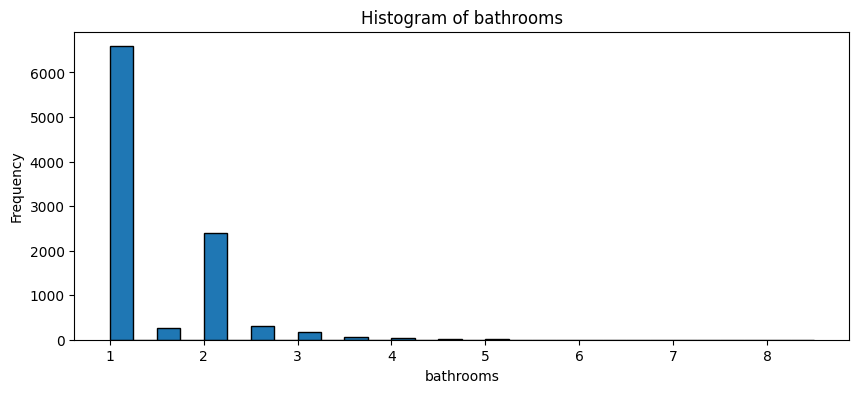

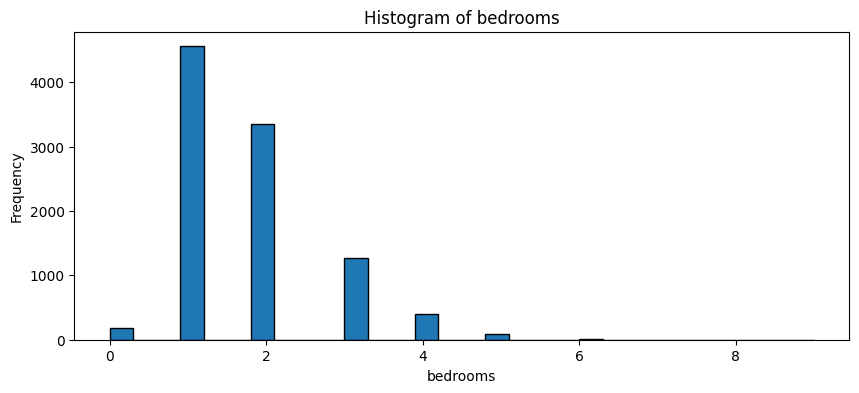

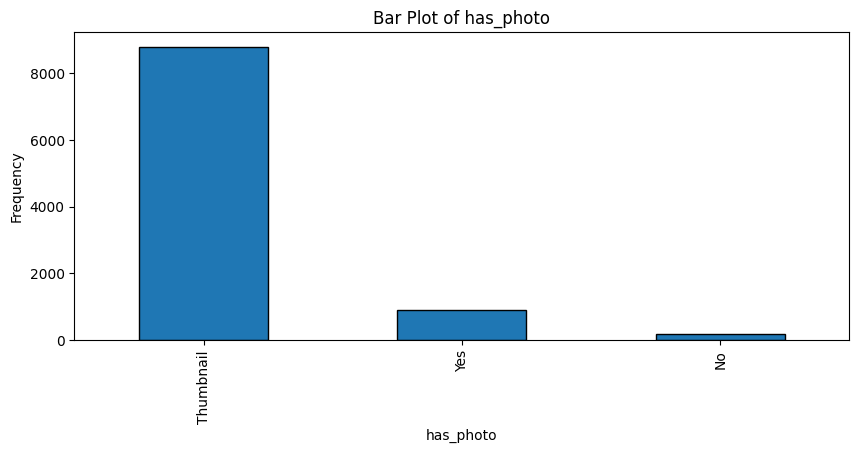

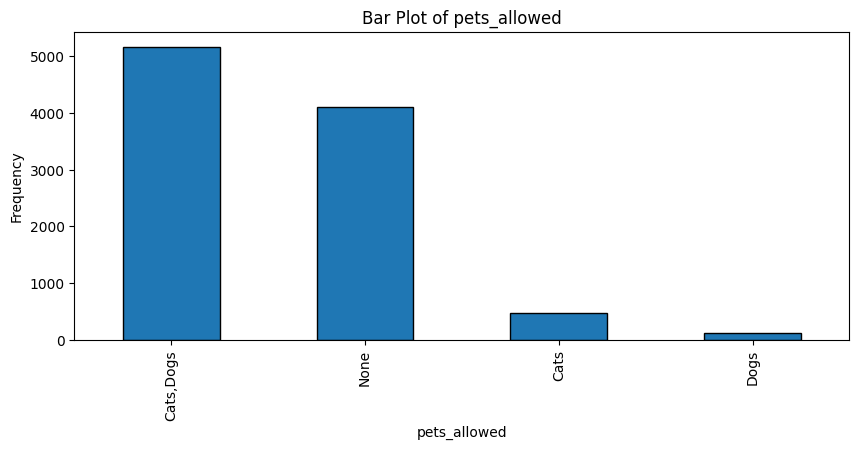

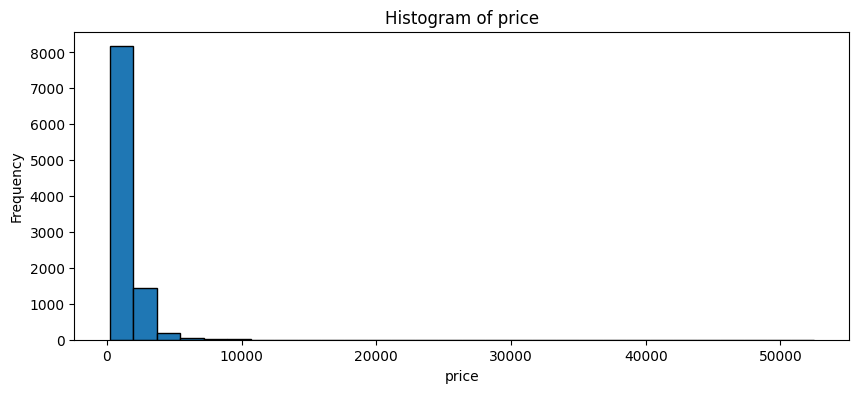

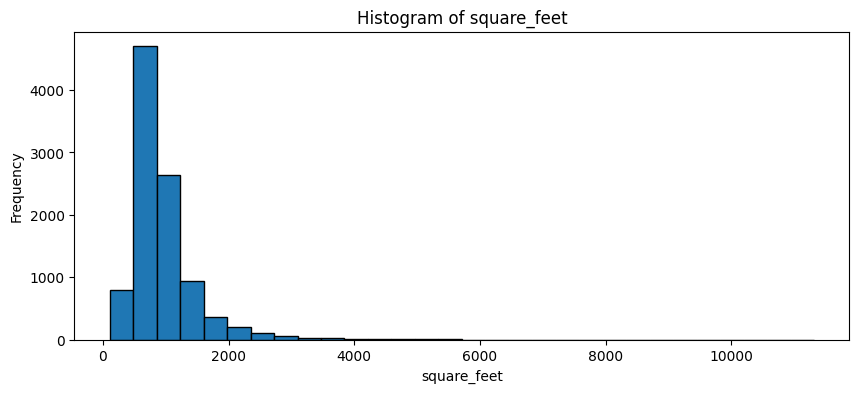

<Figure size 1000x400 with 0 Axes>

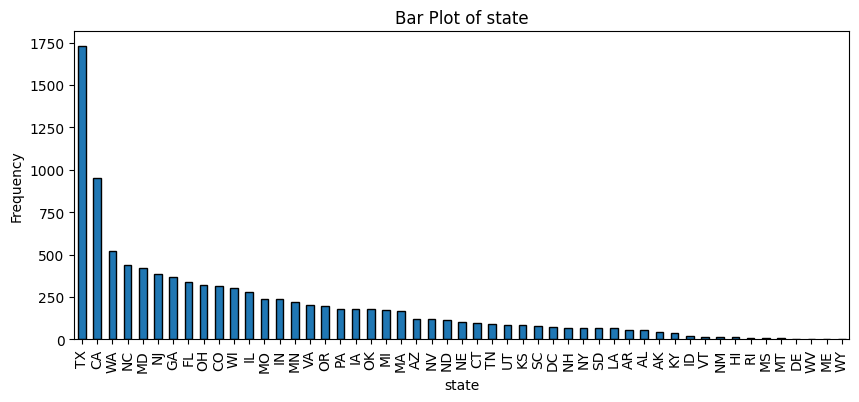

In [16]:
create_histograms(df, numerical_columns, categorical_columns)

Looking at the histogram charts above, we can see that nothing has a normal distribution. everything has a tail to the right. When looking at the categorical columns like state, we see that some states have significantly more listings then others. For the most part, tihs seems to match population, but this is important to remember when forming conclusions.

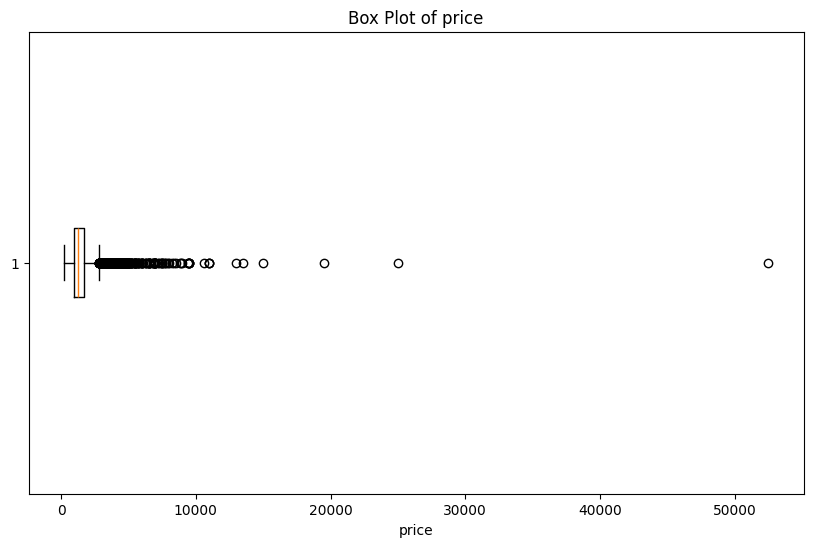

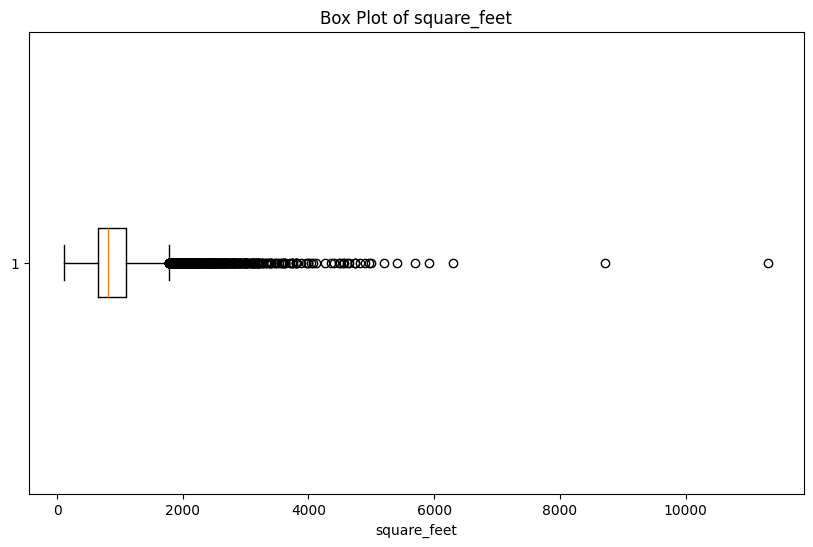

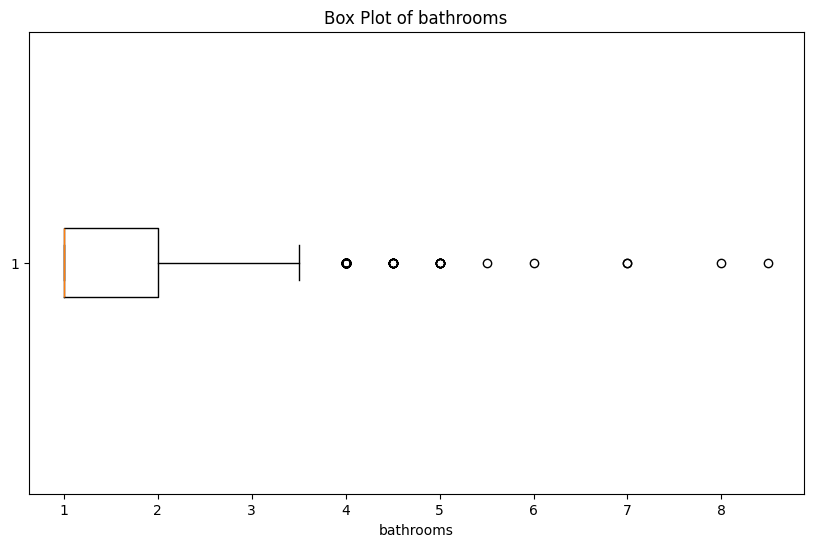

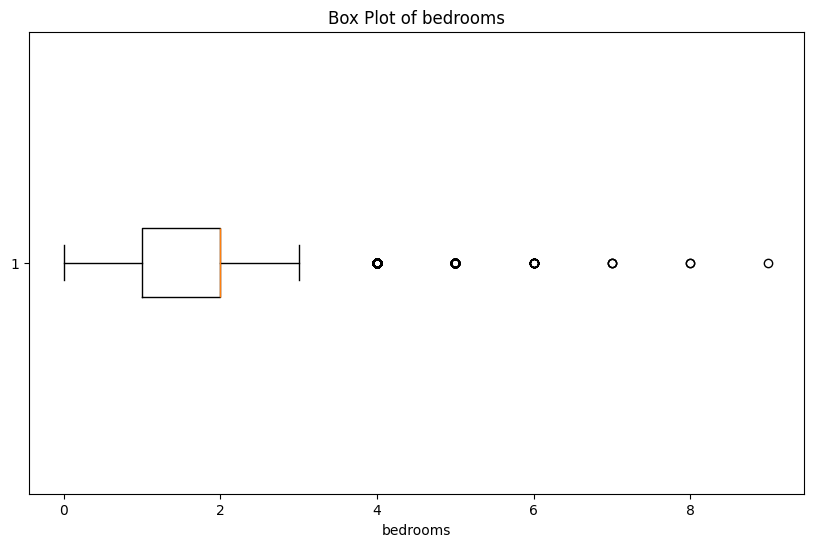

In [17]:
# Create box plots for numerical columns
def create_box_plots(df, numerical_columns):
    for col in numerical_columns:
        plt.figure(figsize=(10, 6))
        plt.boxplot(df[col].dropna(), vert=False)
        plt.title(f'Box Plot of {col}')
        plt.xlabel(col)
        plt.show()
        
create_box_plots(df, numerical_columns)

The Box plots all have alot of outliers on upper end. Some outlier removal will be necessary to proceed.

## Outlier Removal
From the analysis above, we can see that some of the datasets have a lot of outliers, or have long tails. We will clean these outliers below.

In [18]:
def remove_outliers(df, outlier_columns):
    for col in outlier_columns:
        Q1 = df[col].quantile(0.1)
        Q3 = df[col].quantile(0.9)
        IQR = Q3 - Q1
        print(f'{col}: {IQR}')
        lower_bound = Q1 - 1 * IQR
        upper_bound = Q3 + 1 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Define numerical columns
outlier_columns = ['price', 'square_feet']

# Remove outliers from numerical columns
df_cleaned = remove_outliers(df, outlier_columns)

price: 1645.0
square_feet: 953.7999999999993


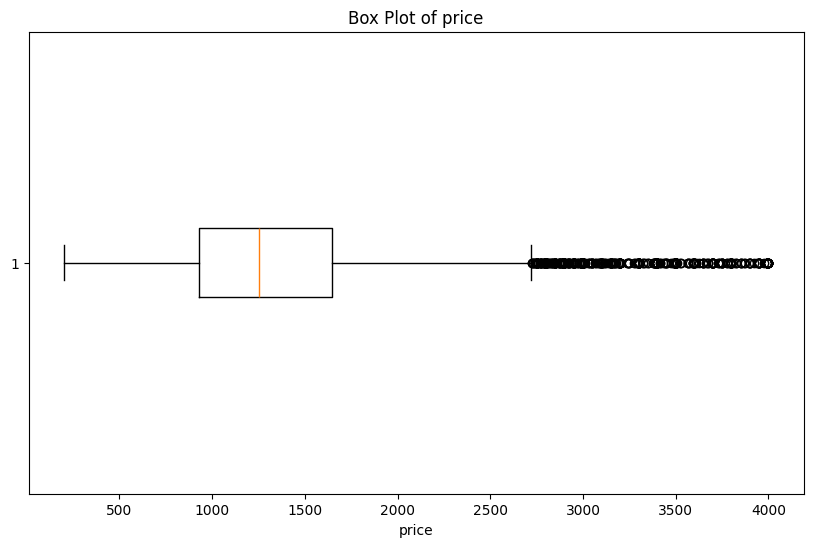

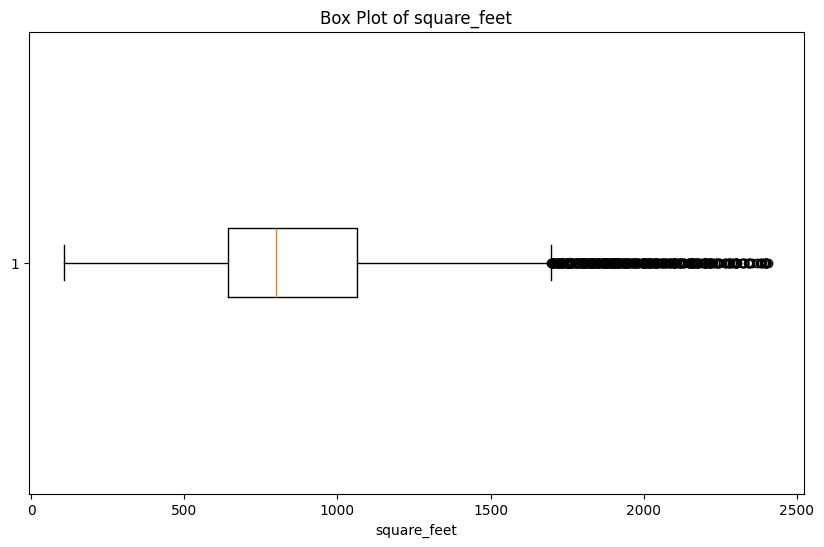

In [19]:
create_box_plots(df_cleaned, outlier_columns)

I decided to leave some outliers specifically due to pricing. While most prices are in the lower range, i did want to keep the data that still seemed reasonable. 

Finally, let's relook at the categorical columns to see if anything else should be updated, but the data looks good for Data Modeling.

In [20]:
categorical_columns = ['has_photo', 'pets_allowed', 'cityname', 'state']

for col in categorical_columns:
    print(df_cleaned[col].value_counts())
    print('-----------------------------------------------------------------------')

has_photo
Thumbnail    8453
Yes           899
No            180
Name: count, dtype: int64
-----------------------------------------------------------------------
pets_allowed
Cats,Dogs    5016
None         3938
Cats          474
Dogs          104
Name: count, dtype: int64
-----------------------------------------------------------------------
cityname
Austin          521
Dallas          213
Houston         185
San Antonio     182
Chicago         146
               ... 
Gonzales          1
Roselle Park      1
Collingswood      1
Saint Marys       1
Sebastian         1
Name: count, Length: 1522, dtype: int64
-----------------------------------------------------------------------
state
TX    1711
CA     823
WA     503
NC     432
MD     416
NJ     375
GA     357
OH     318
FL     315
CO     307
WI     299
IL     276
MO     233
IN     230
MN     216
VA     196
OR     181
PA     180
IA     177
OK     175
MI     166
MA     155
AZ     120
NV     116
ND     110
NE     105
CT      98
TN      86


# Data Modeling

## Preprocessing Columns

In [21]:
df_process = df_cleaned.copy()
df_process.head()

,body,bathrooms,bedrooms,has_photo,pets_allowed,price,square_feet,cityname,state
2,"This unit is located at N Scott St, 14th St N,...",1.0,0.0,Thumbnail,None,1390,107,Arlington,VA
3,"This unit is located at 1717 12th Ave, Seattle...",1.0,0.0,Thumbnail,None,925,116,Seattle,WA
5,**RARE GEM WITH PRIVATE OUTDOOR TERRACE****AVA...,1.0,0.0,Thumbnail,None,2475,130,Manhattan,NY
8,"This unit is located at 333 Hyde St, San Franc...",1.0,0.0,Thumbnail,None,1495,138,San Francisco,CA
14,"This unit is located at 57 Taylor Street, San ...",1.0,0.0,Thumbnail,None,1695,190,San Francisco,CA


Lest start by converting cityname to a frequency, so that we can properly cluster it.

In [22]:
# Convert cityname to frequency count
cityname_freq = df_process['cityname'].value_counts().to_dict()
df_process['cityname_freq'] = df_process['cityname'].map(cityname_freq)

# Define feature columns
categorical_columns = ['has_photo', 'pets_allowed', 'state']
numerical_columns = ['bathrooms', 'bedrooms', 'price', 'square_feet', 'cityname_freq']

# Drop the original cityname column
df_process = df_process.drop(columns=['cityname'], errors='ignore')

We will do our initial analysis without the text column `body`, and will revisit this with Vectorization later. Lets continue to process the categorical columns with OneHotEncoding and numerical columns with MinMaxScaler to create a wholly numeric dataset for use in clustering and PCA.

In [23]:
df_process = df_process.drop(columns=['body'])

# Define column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_columns),
        ('cat', OneHotEncoder(), categorical_columns)
    ]
)

# Define a pipeline that handles the sparse matrix conversion
class DenseTransformer:
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.asarray(X.todense())

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('to_dense', DenseTransformer())
])

X_processed = pipeline.fit_transform(df_process)

## KMeans Clustering
Let's start by performing a basic KMeans Clustering utilizing the Elbow Method to determine an Optimal # of Clusters.

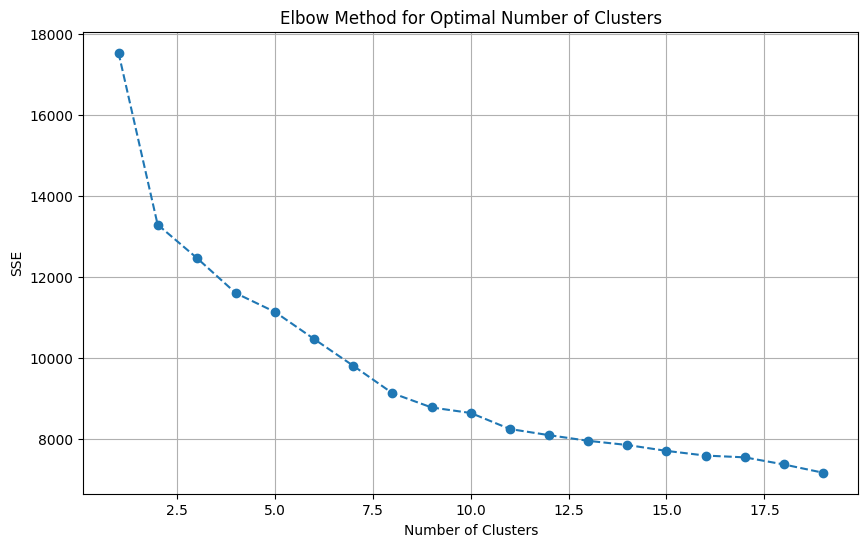

In [24]:
# Determine the optimal number of clusters using the elbow method
sse = []

for k in range(1, 20, 1):
    kmeans = KMeans(n_clusters=k, random_state=37)
    kmeans.fit(X_processed)    
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 20, 1), sse, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid(True)
plt.show()

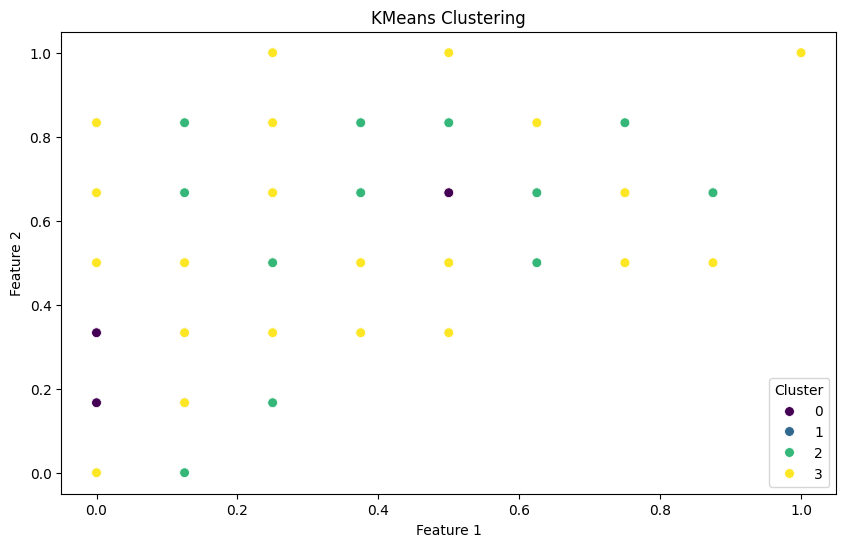

Silhouette Score for 4 clusters: 0.24914439303198602


In [25]:
optimal_clusters = 4

kmeans = KMeans(n_clusters=optimal_clusters, random_state=37)
cluster_labels = kmeans.fit_predict(X_processed)

# Add the cluster labels to the original DataFrame
df_cleaned['cluster'] = cluster_labels

# Visualize the clusters in the first two PCA dimensions
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_processed[:, 0], y=X_processed[:, 1], hue=cluster_labels, palette='viridis', s=50)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('KMeans Clustering')
plt.legend(title='Cluster')
plt.show()

# Calculate the silhouette score
silhouette_avg = silhouette_score(X_processed, cluster_labels)
print(f'Silhouette Score for {optimal_clusters} clusters: {silhouette_avg}')

This resulted in a really low Silhouette Score, so further cleaning may be necessary. Let's start with PCA to see if we can reduce the number of components in the cluster.

## PCA Dimensionality Reduction

Let's reduce the number of dimensions to see if we can remove some of the noise in the dataset.

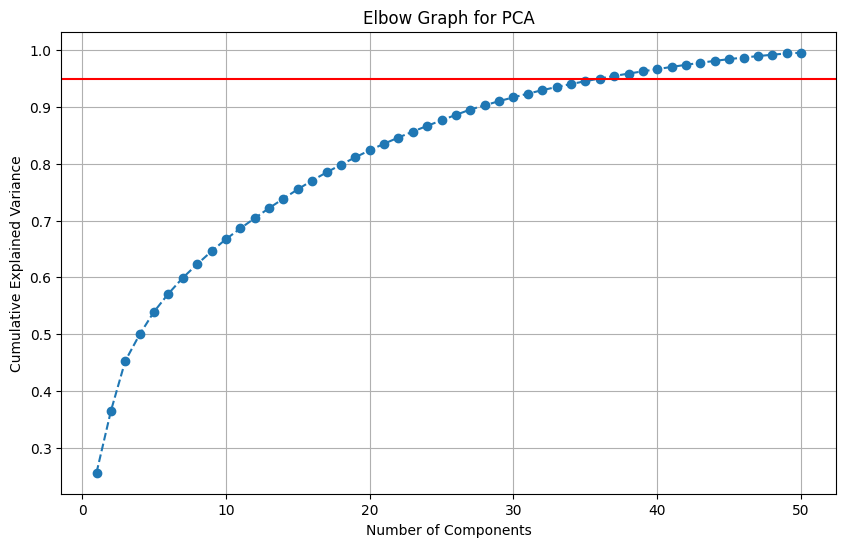

Number of components explaining 95% variance: 36


In [26]:
# Fit and transform the data
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_processed)

# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Elbow Graph for PCA')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.grid(True)
plt.show()

# Find the number of components that explain at least 95% of the variance
n_components_95 = np.argmax(cumulative_explained_variance >= 0.95) + 1
print(f"Number of components explaining 95% variance: {n_components_95}")

In [27]:
pipeline_final = Pipeline([
    ('preprocessor', preprocessor),
    ('to_dense', DenseTransformer()),
    ('pca', PCA(n_components=n_components_95))
])

# Fit and transform the data with the final pipeline
X_pca_final = pipeline_final.fit_transform(df_process)
pca_columns = [f'PC{i+1}' for i in range(n_components_95)]
df_pca = pd.DataFrame(X_pca_final, columns=pca_columns)

print(df_pca.head())

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  0.759304 -0.089800 -0.274043 -0.114498 -0.056740 -0.409388 -0.036507   
1  0.769475 -0.000168 -0.221213 -0.199579  0.013044 -0.488486  0.890809   
2  0.754148 -0.020810 -0.308943 -0.022642 -0.038445 -0.305251  0.006233   
3  0.786869 -0.012396 -0.423494  0.812733  0.117732 -0.426480 -0.066137   
4  0.786900 -0.006978 -0.427669  0.828748  0.113949 -0.398987 -0.057519   

        PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0  0.042625 -0.034757  0.028112 -0.045077  0.012278 -0.037040  0.011710   
1  0.130249  0.122492  0.013395 -0.091511  0.045686 -0.114753 -0.038132   
2 -0.005462 -0.023665  0.082556 -0.062816  0.034230 -0.029446 -0.026394   
3  0.146953  0.055446 -0.042663 -0.011666  0.060782 -0.066748 -0.005056   
4  0.135103  0.052536 -0.034657 -0.016630  0.054407 -0.061826 -0.004566   

       PC15      PC16      PC17      PC18      PC19      PC20      PC21  \
0 -0.022390 -0.087605 -

In [28]:
onehot_features = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_columns)

feature_names = np.concatenate((numerical_columns, onehot_features))
                                
pca_loadings = pd.DataFrame(pipeline_final.named_steps['pca'].components_.T, columns=pca_columns, index=feature_names)
print(pca_loadings.head())

                    PC1       PC2       PC3       PC4       PC5       PC6  \
bathrooms     -0.005771  0.047145 -0.021732  0.012752 -0.120955  0.434666   
bedrooms      -0.009524  0.042500 -0.039145 -0.020665 -0.116568  0.450066   
price          0.008040  0.076937 -0.064846  0.306718 -0.007396  0.272567   
square_feet   -0.017325  0.060553 -0.033691 -0.005633 -0.150070  0.581540   
cityname_freq  0.044781 -0.315947  0.241590  0.087424  0.063577 -0.067243   

                    PC7       PC8       PC9      PC10      PC11      PC12  \
bathrooms      0.034860 -0.071497 -0.013239 -0.033136  0.039477 -0.036123   
bedrooms       0.031120 -0.077435 -0.042543 -0.062129  0.067638 -0.076024   
price          0.149939 -0.175782 -0.036004  0.172143 -0.114396 -0.096094   
square_feet    0.032121 -0.114989 -0.044881 -0.046594  0.046796 -0.058371   
cityname_freq  0.033504  0.066547  0.009324 -0.040174 -0.149903 -0.305401   

                   PC13      PC14      PC15      PC16      PC17      PC18 

After performing PCA we managed to reduce our number of dimensions to 36 while still maintaining 95% of Explained Variance. 

## KMeans Clustering with PCA
In this section we will reperform KMeans with PCA Applied.

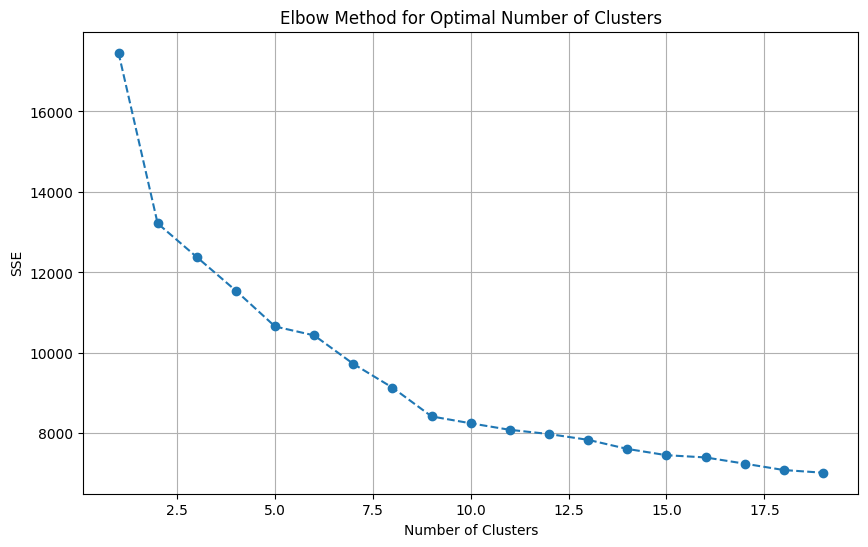

In [29]:
# Determine the optimal number of clusters using the elbow method
sse = []

for k in range(1, 20, 1):
    kmeans = KMeans(n_clusters=k, random_state=37)
    kmeans.fit(X_pca)    
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 20, 1), sse, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid(True)
plt.show()

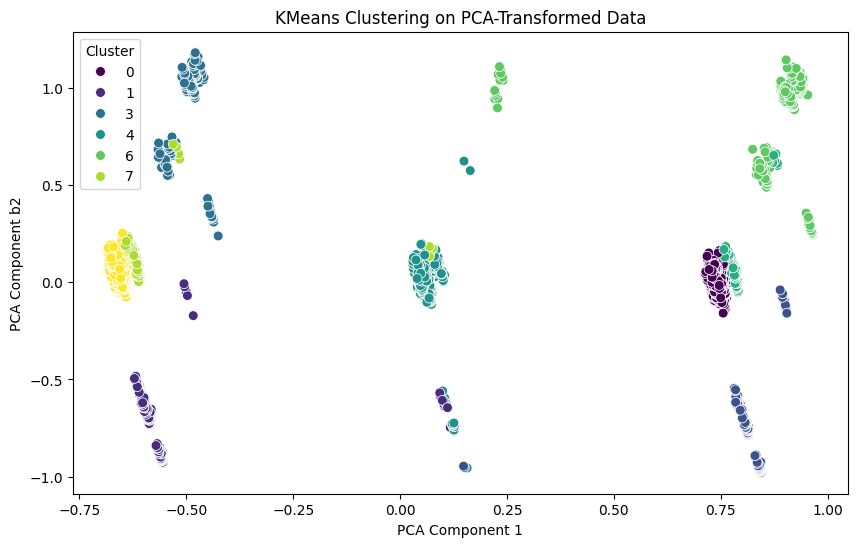

Silhouette Score for 9 clusters: 0.2241716946981393


In [30]:
optimal_clusters = 9

kmeans = KMeans(n_clusters=optimal_clusters, random_state=37)
cluster_labels = kmeans.fit_predict(X_pca)

# Add the cluster labels to the original DataFrame
df_cleaned['cluster'] = cluster_labels

# Visualize the clusters in the first two PCA dimensions
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels, palette='viridis', s=50)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component b2')
plt.title('KMeans Clustering on PCA-Transformed Data')
plt.legend(title='Cluster')
plt.show()

# Calculate the silhouette score
silhouette_avg = silhouette_score(X_pca, cluster_labels)
print(f'Silhouette Score for {optimal_clusters} clusters: {silhouette_avg}')

Reperforming KMeans has caused the optimal number of clusters to change to around 9. PCA did help reduce the number of dimensions, but didnt help improve the model performance. Let's continue to model the data to learn more about this dataset.

## DBSCAN Clustering

DBSCAN is a useful tool because it doesnt require us to set how many clusters we want. This could be useful in determining the optimal number of clusters and getting more insight about the data.

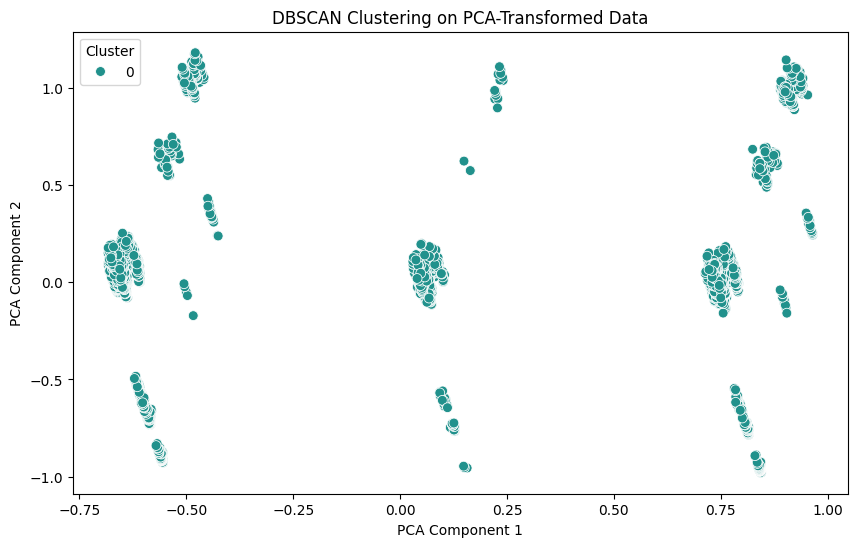

There is only 1 cluster


In [31]:
# Run DBSCAN clustering
dbscan = DBSCAN(eps=3, min_samples=5)
cluster_labels_dbscan = dbscan.fit_predict(X_pca)

# Add the cluster labels to the original DataFrame
df_cleaned['cluster_dbscan'] = cluster_labels_dbscan

# Visualize the clusters in the first two PCA dimensions
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels_dbscan, palette='viridis', s=50)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('DBSCAN Clustering on PCA-Transformed Data')
plt.legend(title='Cluster')
plt.show()

# Calculate the silhouette score
try:
    silhouette_avg_dbscan = silhouette_score(X_pca, cluster_labels_dbscan)
    print(f'Silhouette Score for DBSCAN clusters: {silhouette_avg_dbscan}')
except:
    print('There is only 1 cluster')

DBSCAN returned that the otimal number of clusters is one. this means that it is incredibly difficult to cluster the data with any basic method and it may be necessary to look more into the data.

## Agglomerative Clustering

Let's see if hierarchical clustering helps produce any different results.

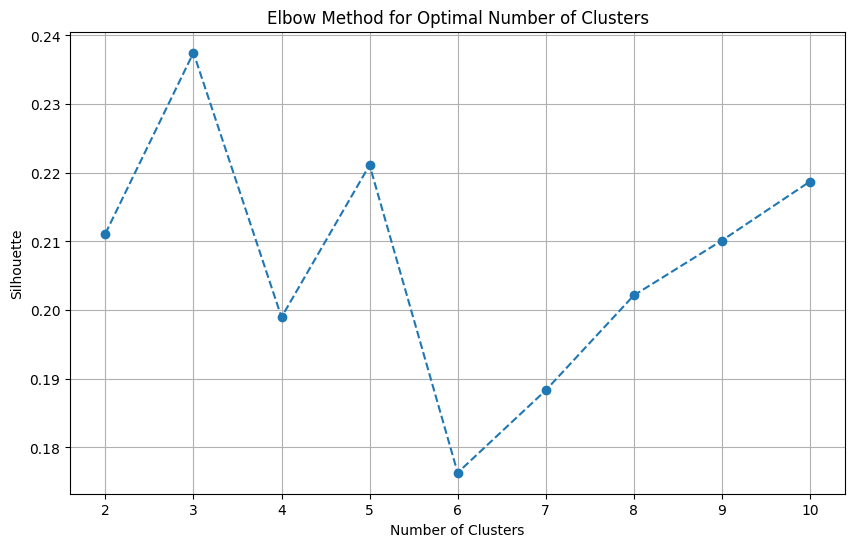

In [32]:
silhouette_scores = []

# Loop through the cluster range and perform Agglomerative Clustering
for k in range(2, 11):
    agglo = AgglomerativeClustering(n_clusters=k)
    cluster_labels_agglo = agglo.fit_predict(X_pca)
    
    # Calculate the silhouette score
    silhouette_avg_agglo = silhouette_score(X_pca, cluster_labels_agglo)
    silhouette_scores.append(silhouette_avg_agglo)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid(True)
plt.show()

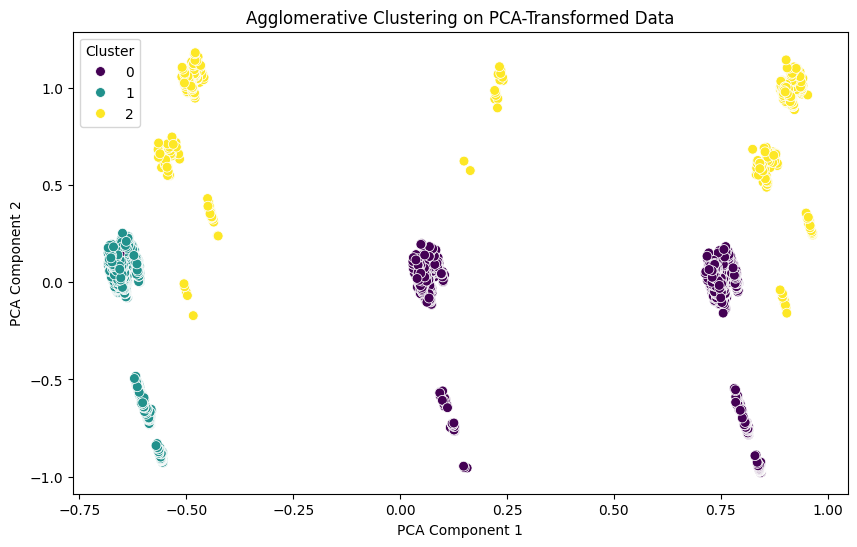

Silhouette Score for Agglomerative Clustering: 0.2374910024021249


In [33]:
# Hierarchical clustering
agglo = AgglomerativeClustering(n_clusters=3)  # You can change the number of clusters
cluster_labels_agglo = agglo.fit_predict(X_pca)

# Add the cluster labels to the original DataFrame
df_cleaned['cluster_agglo'] = cluster_labels_agglo

# Visualize the clusters in the first two PCA dimensions
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels_agglo, palette='viridis', s=50)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Agglomerative Clustering on PCA-Transformed Data')
plt.legend(title='Cluster')
plt.show()

# Calculate the silhouette score
silhouette_avg_agglo = silhouette_score(X_pca, cluster_labels_agglo)
print(f'Silhouette Score for Agglomerative Clustering: {silhouette_avg_agglo}')

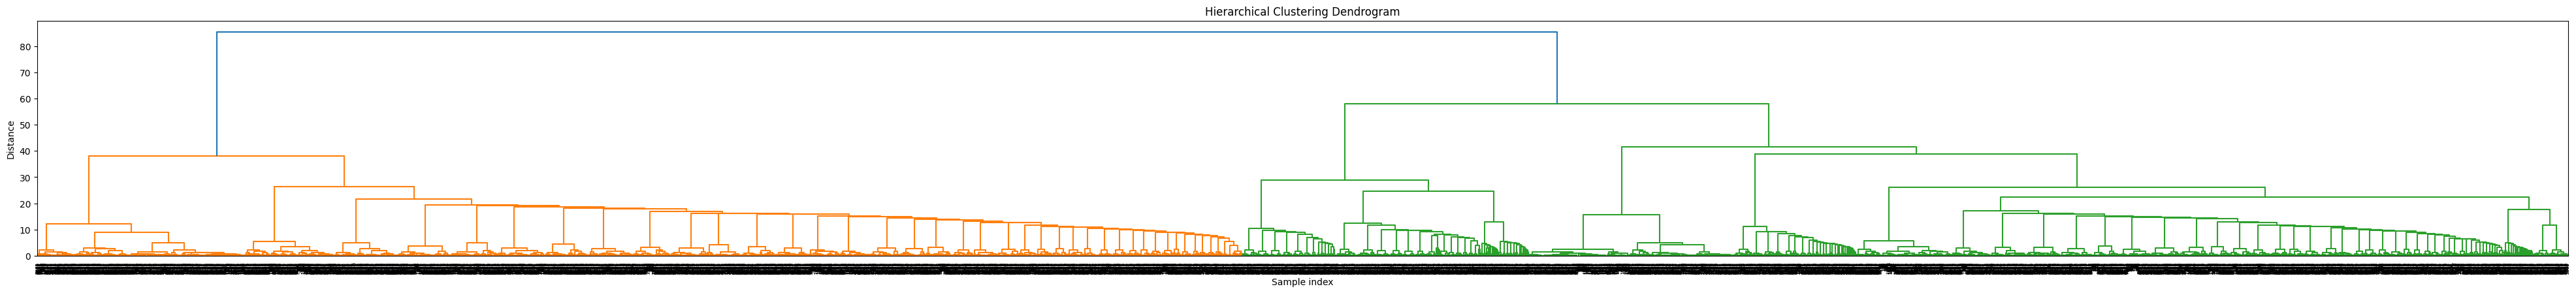

In [34]:
Z = linkage(X_pca, method='ward')

fig, ax = plt.subplots(figsize=(50, 45))
dendrogram(Z, ax=ax)
fig.subplots_adjust(bottom=.8)
ax.set_title('Hierarchical Clustering Dendrogram')
ax.set_xlabel('Sample index')
ax.set_ylabel('Distance')

plt.show()

Hierarchical Clustering is showing somewhere between 3 and 6 clusters would be optimal. Clustering is likely not a good method for this dataset without adding more information about the listings or cleaning up the datasource quite a bit.

## Modeling with Vectorization
Let's try to model the data with the body column and the information it has that may benefit the model. We will start by cleaning the text by lemmatizing it and performign general cleaning to prepare it for TF-IDF Vectorization.

### Clean Text

In [35]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to clean text data
def clean_text(text):
    text = str(text)
    text = re.split(r'[,\s/]+', text)
    text = ' '.join(text)
    text = re.sub(r'[^a-zA-Z\s]', '', text).lower()
    # Tokenize text
    tokens = word_tokenize(text)
    # lemmatize
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    # Join cleaned tokens back into a single string
    return ' '.join(tokens)

In [36]:
df_cleaned.head()

,body,bathrooms,bedrooms,has_photo,pets_allowed,price,square_feet,cityname,state,cluster,cluster_dbscan,cluster_agglo
2,"This unit is located at N Scott St, 14th St N,...",1.0,0.0,Thumbnail,None,1390,107,Arlington,VA,0,0,0
3,"This unit is located at 1717 12th Ave, Seattle...",1.0,0.0,Thumbnail,None,925,116,Seattle,WA,0,0,0
5,**RARE GEM WITH PRIVATE OUTDOOR TERRACE****AVA...,1.0,0.0,Thumbnail,None,2475,130,Manhattan,NY,0,0,0
8,"This unit is located at 333 Hyde St, San Franc...",1.0,0.0,Thumbnail,None,1495,138,San Francisco,CA,5,0,0
14,"This unit is located at 57 Taylor Street, San ...",1.0,0.0,Thumbnail,None,1695,190,San Francisco,CA,5,0,0


In [37]:
df_cleaned['body'] = df_cleaned['body'].apply(clean_text)
df_cleaned.head()

,body,bathrooms,bedrooms,has_photo,pets_allowed,price,square_feet,cityname,state,cluster,cluster_dbscan,cluster_agglo
2,unit located n scott st th st n arlington va a...,1.0,0.0,Thumbnail,None,1390,107,Arlington,VA,0,0,0
3,unit located th ave seattle wamonthly rental r...,1.0,0.0,Thumbnail,None,925,116,Seattle,WA,0,0,0
5,rare gem private outdoor terraceavailable imme...,1.0,0.0,Thumbnail,None,2475,130,Manhattan,NY,0,0,0
8,unit located hyde st san francisco camonthly r...,1.0,0.0,Thumbnail,None,1495,138,San Francisco,CA,5,0,0
14,unit located taylor street san francisco camon...,1.0,0.0,Thumbnail,None,1695,190,San Francisco,CA,5,0,0


In [38]:
display(df_cleaned['body'][54])

'unit located acama street studio city camonthly rental rate range bed unit available rent apartment available amenity furnished'

### TF-IDF Vectorization
Lets vectorize the data into important words, so we can use it for clustering.

In [39]:
# TF-IDF vectorizer for the combined text column
tfidf_vectorizer = TfidfVectorizer(max_features=500, stop_words='english')

# Fit and transform the combined text column
tfidf = tfidf_vectorizer.fit_transform(df_cleaned['body'])

# Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df

,ac,access,activity,additional,adult,advantage,agent,aggressive,air,airport,allowed,amazing,amenity,ample,antonio,apartment,appliance,application,apply,area,array,art,atlanta,attached,austin,available,ave,avenue,away,azmonthly,balcony,baltimore,bar,basketball,bath,bathroom,bathtub,bbq,bd,beach,beautiful,beautifully,bed,bedroom,best,bike,blvd,boast,brand,breakfast,breed,bright,building,built,bus,business,cabinet,cabinetry,cable,camonthly,car,care,carpet,carpeting,cat,ceiling,center,central,charge,chicago,childrens,choice,choose,city,close,closet,cloth,club,coffee,colorado,columbia,come,comfort,comfortable,coming,comment,community,commute,comonthly,complete,conditioned,conditioner,connection,contact,contemporary,controlled,convenience,convenient,conveniently,corner,counter,county,course,court,cozy,creek,criterion,crossing,ct,ctr,custom,dallas,day,dc,deck,dedicated,denver,deposit,deserve,design,designed,designer,desirable,dining,discover,dishwasher,disposal,distance,district,dog,door,downtown,dr,drier,drive,dryer,east,easy,efficient,electric,elevator,emergency,end,energy,enjoy,entertaining,entertainment,entry,equipped,exact,exceptional,expansive,experience,expert,extra,facility,fall,family,fan,feature,featuring,fee,feel,finish,fireplace,fitness,fixture,flmonthly,floor,flooring,foot,footage,free,freeway,friend,friendly,ft,fullsize,fully,furnished,gamonthly,garage,garbage,garden,gas,gated,golf,gorgeous,gourmet,granite,great,green,grill,grilling,ground,handicapped,hard,hardwood,heart,heat,heated,height,high,highend,highway,hill,historic,home,hookup,hospital,hot,hour,house,household,hr,iamonthly,id,ideal,ilmonthly,include,included,includes,including,income,indoor,info,information,inmonthly,inside,insurance,interior,internet,interstate,inunit,kitchen,la,lake,landscaped,landscaping,lane,large,laundry,layout,lease,leasing,level,life,lifestyle,light,lighting,like,limit,line,list,live,living,local,located,location,loft,look,looking,lot,lounge,love,luxurious,luxury,madison,main,maintenance,major,make,mall,management,match,max,md,meet,mi,microwave,mile,mimonthly,mind,minute,mnmonthly,mo,modern,momonthly,month,monthly,mountain,natural,nc,ncmonthly,nd,ne,near,nearby,need,neighborhood,nestled,new,newly,nj,north,number,nw,oak,offer,offering,office,ohmonthly,ok,oklahoma,old,online,onsite,open,option,ormonthly,outdoor,outside,oven,overhead,oversized,package,paint,park,parking,patio,payment,peaceful,perfect,pet,petfriendly,philadelphia,picnic,pit,place,plan,play,playground,plenty,plus,pool,pound,premier,premium,price,private,professional,property,provide,provides,proximity,public,quality,quartz,quick,quiet,raleigh,range,rate,rd,ready,rebate,recently,recreation,refrigerator,relax,relaxing,remodeled,removal,rent,rental,renter,required,requirement,residence,resident,residential,resortstyle,responsible,restaurant,restriction,ridge,right,river,road,room,run,san,schedule,school,se,search,seattle,secure,select,service,set,setting,sewer,sheltered,shop,shopping,short,site,situated,size,small,south,spa,space,spacious,sparkling,special,spring,sq,sqft,square,st,staff,stainless,state,stateoftheart,station,step,stop,storage,stove,street,stroll,studio,stunning,style,sundeck,sure,surface,swimming,tax,team,tenant,tennis,term,terrace,th,theater,tile,time,today,tohome,total,tour,town,townhomes,trail,transportation,trash,tree,twentyfour,txmonthly,unique,unit,university,updated,upgrade,upgraded,upscale,uptodate,urban,utility,valley,variety,view,village,visit,walk,walkable,walkin,wamonthly,want,washer,washerdryer,washington,water,way,weight,welcome,west,wide,wifi,wimonthly,window,wonderful,wood,wooded,work,yard,youll
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.139375,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0

### Clustering Prep

We will reprocess the data with the body column so  that we van vectorize it properly. 


In [40]:
df_process = df_cleaned.copy()
df_process.head()

,body,bathrooms,bedrooms,has_photo,pets_allowed,price,square_feet,cityname,state,cluster,cluster_dbscan,cluster_agglo
2,unit located n scott st th st n arlington va a...,1.0,0.0,Thumbnail,None,1390,107,Arlington,VA,0,0,0
3,unit located th ave seattle wamonthly rental r...,1.0,0.0,Thumbnail,None,925,116,Seattle,WA,0,0,0
5,rare gem private outdoor terraceavailable imme...,1.0,0.0,Thumbnail,None,2475,130,Manhattan,NY,0,0,0
8,unit located hyde st san francisco camonthly r...,1.0,0.0,Thumbnail,None,1495,138,San Francisco,CA,5,0,0
14,unit located taylor street san francisco camon...,1.0,0.0,Thumbnail,None,1695,190,San Francisco,CA,5,0,0


In [41]:
# Convert cityname to frequency count
cityname_freq = df_process['cityname'].value_counts().to_dict()
df_process['cityname_freq'] = df_process['cityname'].map(cityname_freq)

# Define feature columns
categorical_columns = ['has_photo', 'pets_allowed', 'state']
numerical_columns = ['bathrooms', 'bedrooms', 'price', 'square_feet', 'cityname_freq']

# Drop the original cityname column
df_process = df_process.drop(columns=['cityname'], errors='ignore')

In [42]:
# Define column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_columns),
        ('cat', OneHotEncoder(), categorical_columns),
        ('text', TfidfVectorizer(max_features=500, stop_words='english'), 'body')
    ]
)

# Define a pipeline that handles the sparse matrix conversion
class DenseTransformer:
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.asarray(X.todense())

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('to_dense', DenseTransformer())
])

X_processed = pipeline.fit_transform(df_process)

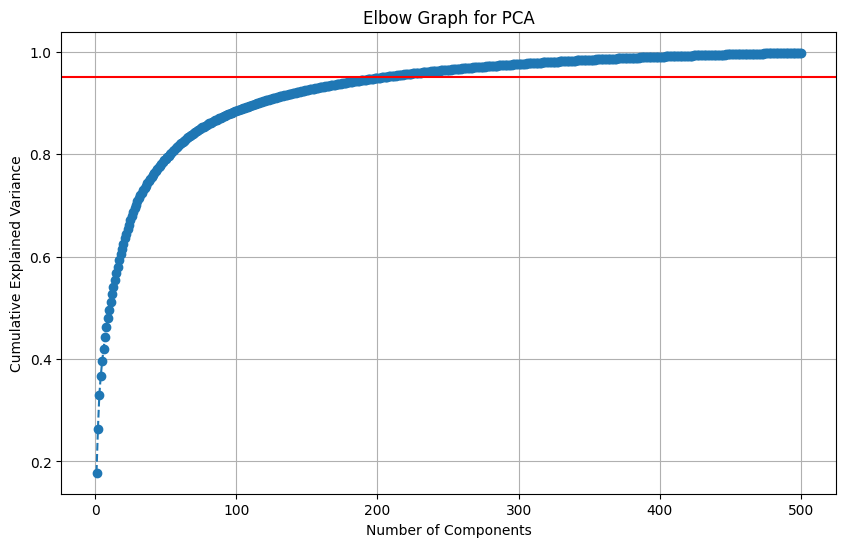

Number of components explaining 95% variance: 203


In [43]:
# Fit and transform the data
pca = PCA(n_components=500)
X_pca = pca.fit_transform(X_processed)

# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Elbow Graph for PCA')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.grid(True)
plt.show()

# Find the number of components that explain at least 95% of the variance
n_components_95 = np.argmax(cumulative_explained_variance >= 0.95) + 1
print(f"Number of components explaining 95% variance: {n_components_95}")

With the new updated PCA, we now have over 203 variables which include alot of vectorized terms from the earlier Vectorization process.

In [44]:
pipeline_final = Pipeline([
    ('preprocessor', preprocessor),
    ('to_dense', DenseTransformer()),
    ('pca', PCA(n_components=n_components_95))
])

# Fit and transform the data with the final pipeline
X_pca_final = pipeline_final.fit_transform(df_process)
pca_columns = [f'PC{i+1}' for i in range(n_components_95)]
df_pca = pd.DataFrame(X_pca_final, columns=pca_columns)

print(df_pca.head())

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  0.741267 -0.168169 -0.335826 -0.116745  0.024468 -0.203232 -0.315988   
1  0.753570 -0.059966 -0.286054 -0.185313  0.133411 -0.098844 -0.844444   
2  0.767332  0.077792 -0.249834 -0.132653 -0.056792 -0.379691  0.057939   
3  0.759248 -0.109152 -0.527420  0.799472  0.159382 -0.583710 -0.073257   
4  0.772690 -0.060069 -0.492432  0.760257  0.116539 -0.582463  0.012800   

        PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0 -0.126285  0.004048  0.199583  0.150633  0.051285 -0.063403 -0.040059   
1  0.782797  0.154702  0.186134  0.034722  0.092066 -0.054774 -0.084608   
2  0.115118 -0.022309  0.042197  0.124452  0.043452 -0.000573 -0.095035   
3 -0.040665  0.160486  0.009531 -0.055121  0.041396 -0.044528 -0.042853   
4  0.007095  0.145193  0.005570 -0.019702  0.058880 -0.043732 -0.041418   

       PC15      PC16      PC17      PC18      PC19      PC20      PC21  \
0 -0.109476 -0.057166 -

In [45]:
onehot_features = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_columns)
tfidf_features = pipeline.named_steps['preprocessor'].transformers_[2][1].get_feature_names_out()

feature_names = np.concatenate((numerical_columns, onehot_features))
feature_names = np.concatenate((numerical_columns, onehot_features, tfidf_features))
                                
pca_loadings = pd.DataFrame(pipeline_final.named_steps['pca'].components_.T, columns=pca_columns, index=feature_names)
print(pca_loadings.head())

                    PC1       PC2       PC3       PC4       PC5       PC6  \
bathrooms     -0.004488  0.040025 -0.019361  0.039478 -0.164603  0.331966   
bedrooms      -0.009215  0.032080 -0.038784  0.009637 -0.147959  0.353384   
price          0.009258  0.059777 -0.067832  0.290655 -0.058026  0.149599   
square_feet   -0.015866  0.050204 -0.030582  0.034205 -0.205880  0.457364   
cityname_freq  0.045149 -0.297538  0.248255  0.077564  0.072323 -0.025714   

                    PC7       PC8       PC9      PC10      PC11      PC12  \
bathrooms      0.140575  0.042090 -0.049481 -0.118758 -0.084158 -0.040087   
bedrooms       0.115321  0.001528 -0.047512 -0.174345 -0.122548 -0.068752   
price          0.097068  0.194051 -0.158358 -0.069407  0.072703 -0.131410   
square_feet    0.187736  0.034434 -0.087016 -0.185143 -0.111731 -0.057854   
cityname_freq -0.092050 -0.023103  0.065224  0.185140  0.084980  0.044215   

                   PC13      PC14      PC15      PC16      PC17      PC18 

In [46]:
# Determine the optimal number of clusters using the elbow method
sse = []
silhouette = []

for k in range(2, 100, 2):
    kmeans = KMeans(n_clusters=k, random_state=37)
    kmeans.fit(X_pca)    
    sse.append(kmeans.inertia_)
    
    cluster_labels = kmeans.fit_predict(X_pca)
    df_cleaned['cluster'] = cluster_labels
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    silhouette.append(silhouette_avg)

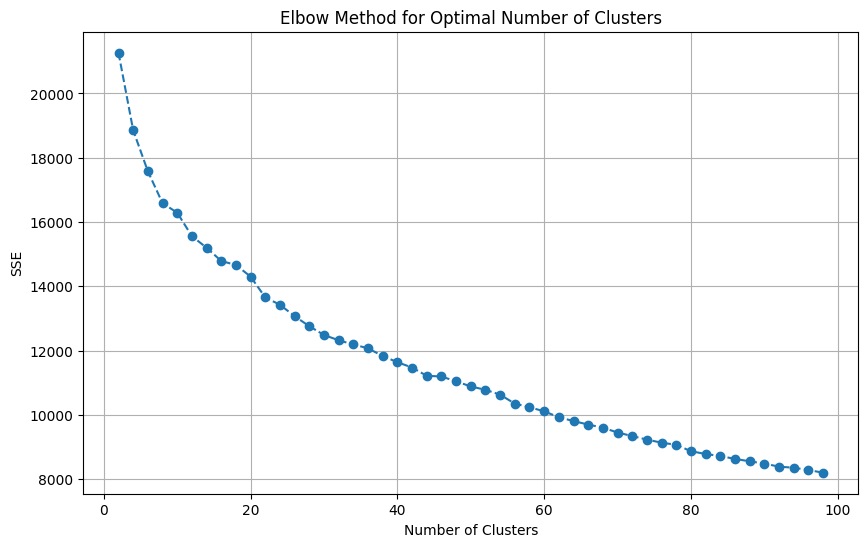

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(range(2, 100, 2), sse, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid(True)
plt.show()

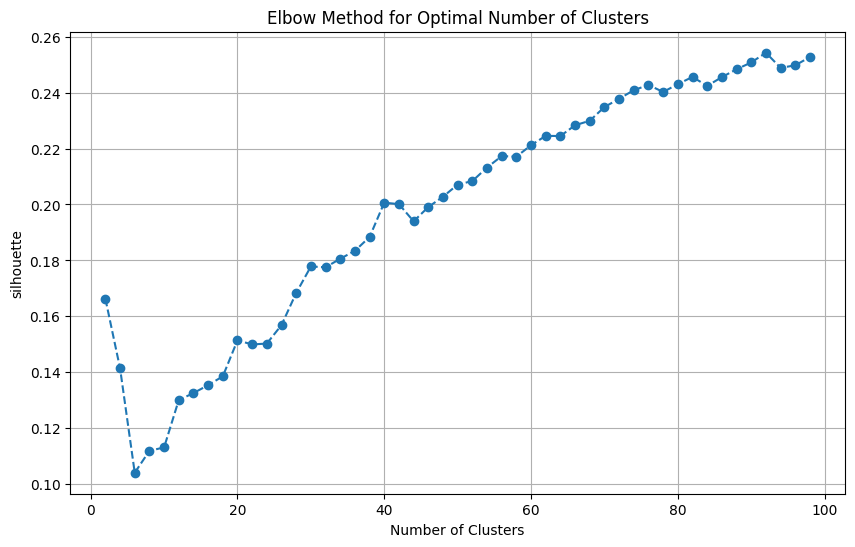

In [48]:
plt.figure(figsize=(10, 6))
plt.plot(range(2, 100, 2), silhouette, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('silhouette')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid(True)
plt.show()

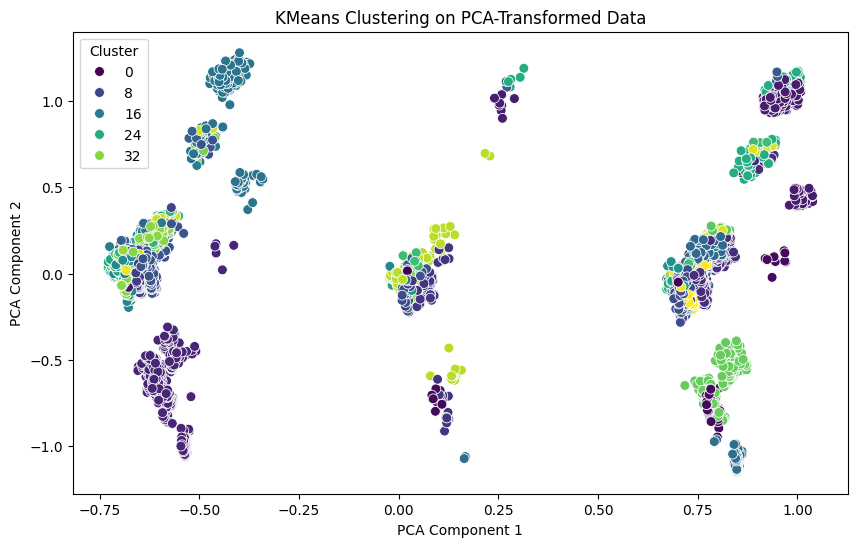

Silhouette Score for 40 clusters: 0.20064570552689684


In [49]:
optimal_clusters = 40

kmeans = KMeans(n_clusters=optimal_clusters, random_state=37)
cluster_labels = kmeans.fit_predict(X_pca)

# Add the cluster labels to the original DataFrame
df_cleaned['cluster'] = cluster_labels

# Visualize the clusters in the first two PCA dimensions
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels, palette='viridis', s=50)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('KMeans Clustering on PCA-Transformed Data')
plt.legend(title='Cluster')
plt.show()

# Calculate the silhouette score
silhouette_avg = silhouette_score(X_pca, cluster_labels)
print(f'Silhouette Score for {optimal_clusters} clusters: {silhouette_avg}')

Looking at Silhouette Score has resulted in around 40 clusters being more optimal. However, when looking at the clusters there is very little segregation between the clusters. Looking at SSE, the optimal number of clusters may be around 15 clusters. Overall though, clustering did not perform well.

## Linear Models

Now let's try a Linear model to predict price based off the data. We will start over with processing so we can split the data into a train and test set prior to processing the data.

In [50]:
df_process = df_cleaned.copy()
df_process.head()

,body,bathrooms,bedrooms,has_photo,pets_allowed,price,square_feet,cityname,state,cluster,cluster_dbscan,cluster_agglo
2,unit located n scott st th st n arlington va a...,1.0,0.0,Thumbnail,None,1390,107,Arlington,VA,9,0,0
3,unit located th ave seattle wamonthly rental r...,1.0,0.0,Thumbnail,None,925,116,Seattle,WA,27,0,0
5,rare gem private outdoor terraceavailable imme...,1.0,0.0,Thumbnail,None,2475,130,Manhattan,NY,13,0,0
8,unit located hyde st san francisco camonthly r...,1.0,0.0,Thumbnail,None,1495,138,San Francisco,CA,5,0,0
14,unit located taylor street san francisco camon...,1.0,0.0,Thumbnail,None,1695,190,San Francisco,CA,5,0,0


In [51]:
cityname_freq = df_process['cityname'].value_counts().to_dict()
df_process['cityname_freq'] = df_process['cityname'].map(cityname_freq)

# Define feature columns
categorical_columns = ['has_photo', 'pets_allowed', 'state']
numerical_columns = ['bathrooms', 'bedrooms', 'square_feet', 'cityname_freq']

# Drop the original cityname column
df_process = df_process.drop(columns=['cityname','body'], errors='ignore')

# Define column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_columns),
        ('cat', OneHotEncoder(), categorical_columns)
    ]
)

# Define a pipeline that handles the sparse matrix conversion
class DenseTransformer:
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.asarray(X.todense())

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('to_dense', DenseTransformer())
])

# Separate features and target variable
features = df_process.drop(['price'], axis=1)
target = df_process['price']

# Preprocess the features
X_processed = pipeline.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(X_processed, target, test_size=0.2, random_state=37)

## Linear Regression

In [52]:
# Initialize and fit the Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Make predictions with Linear Regression
linear_predictions = linear_model.predict(X_test)

# Evaluate the Linear Regression model
linear_mse = mean_squared_error(y_test, linear_predictions)
linear_r2 = r2_score(y_test, linear_predictions)

print(f"Linear Regression Mean Squared Error: {linear_mse}")
print(f"Linear Regression R-squared Score: {linear_r2}")


Linear Regression Mean Squared Error: 171248.99357629786
Linear Regression R-squared Score: 0.5570673526442191


Basic Linear regression resulted in a 55% R^2. This is still not capturing alot of the variance in the data, so let's check Ridge Regression to see if we can finetune the alpha and improve performance at all.

## Ridge Regression

In [53]:
# Initialize and fit the Ridge Regression model
ridge_model = Ridge()

#Grid Search
param_grid = {'alpha': np.logspace(-6, 6, 13)}

grid_search = GridSearchCV(ridge_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_ridge_model = grid_search.best_estimator_
ridge_predictions = best_ridge_model.predict(X_test)

ridge_mse = mean_squared_error(y_test, ridge_predictions)
ridge_r2 = r2_score(y_test, ridge_predictions)

print(f"Best Ridge Regression Alpha: {grid_search.best_params_['alpha']}")
print(f"Ridge Regression Mean Squared Error: {ridge_mse}")
print(f"Ridge Regression R-squared Score: {ridge_r2}")

# Cross-validation
linear_cv_scores = cross_val_score(linear_model, X_processed, target, cv=5, scoring='neg_mean_squared_error')
ridge_cv_scores = cross_val_score(best_ridge_model, X_processed, target, cv=5, scoring='neg_mean_squared_error')

print(f"Linear Regression CV Mean Squared Error: {-np.mean(linear_cv_scores)}")
print(f"Ridge Regression CV Mean Squared Error: {-np.mean(ridge_cv_scores)}")

Best Ridge Regression Alpha: 1.0
Ridge Regression Mean Squared Error: 171095.719938857
Ridge Regression R-squared Score: 0.557463792334659
Linear Regression CV Mean Squared Error: 3.10625736261678e+24
Ridge Regression CV Mean Squared Error: 165604.0440727405


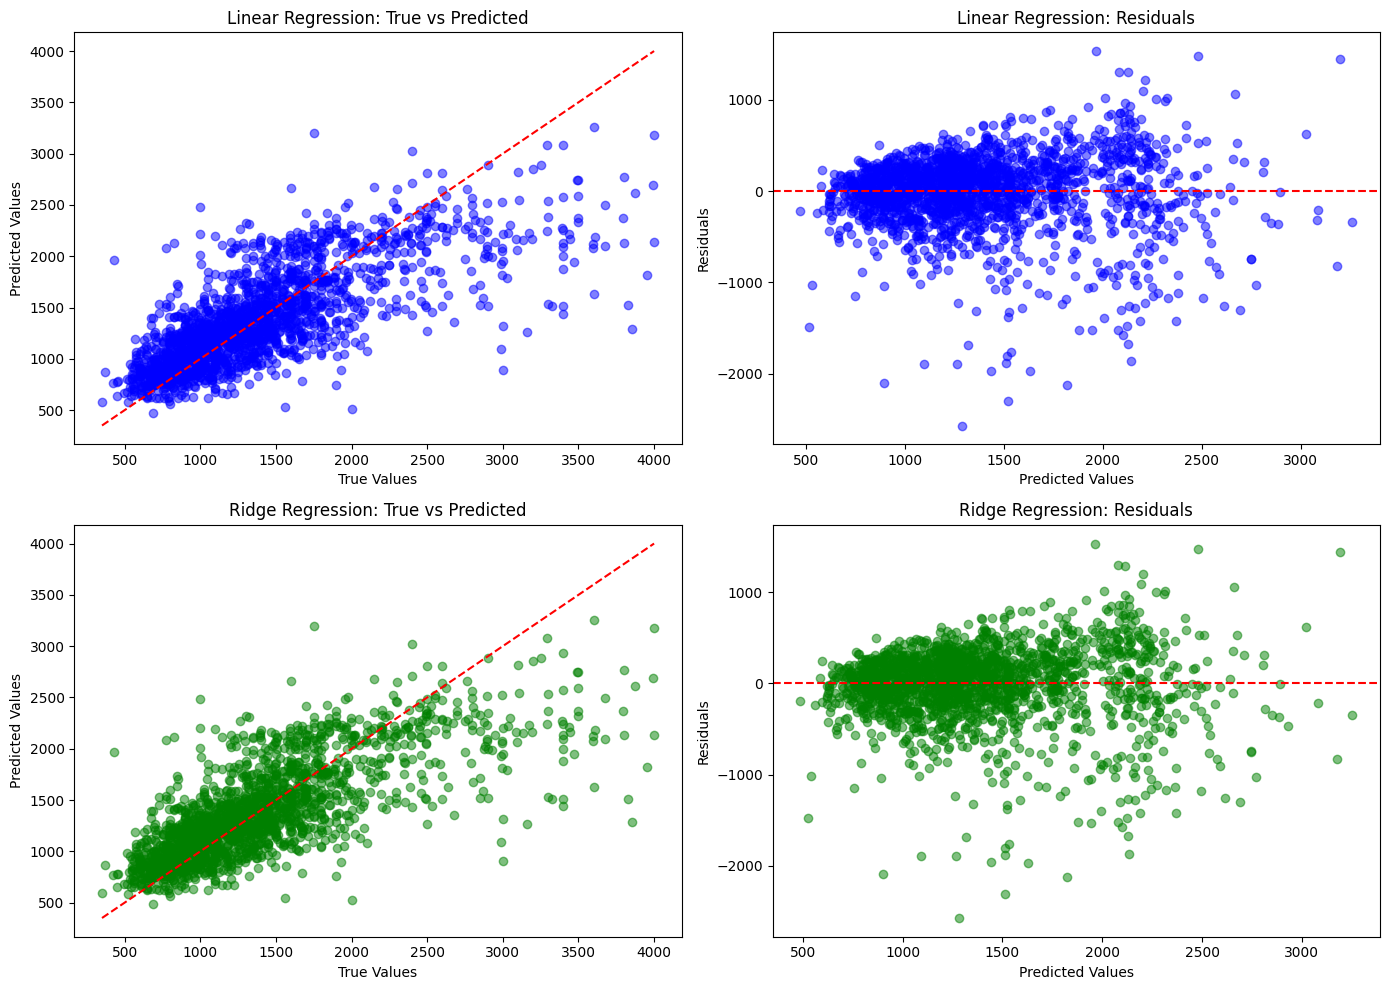

In [54]:
# Predictions
linear_predictions = linear_model.predict(X_test)
ridge_predictions = best_ridge_model.predict(X_test)

# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

# Plot true vs predicted values for Linear Regression
axes[0, 0].scatter(y_test, linear_predictions, alpha=0.5, color='blue')
axes[0, 0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
axes[0, 0].set_title('Linear Regression: True vs Predicted')
axes[0, 0].set_xlabel('True Values')
axes[0, 0].set_ylabel('Predicted Values')

# Plot residuals for Linear Regression
axes[0, 1].scatter(linear_predictions, linear_predictions - y_test, alpha=0.5, color='blue')
axes[0, 1].axhline(y=0, color='red', linestyle='--')
axes[0, 1].set_title('Linear Regression: Residuals')
axes[0, 1].set_xlabel('Predicted Values')
axes[0, 1].set_ylabel('Residuals')

# Plot true vs predicted values for Ridge Regression
axes[1, 0].scatter(y_test, ridge_predictions, alpha=0.5, color='green')
axes[1, 0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
axes[1, 0].set_title('Ridge Regression: True vs Predicted')
axes[1, 0].set_xlabel('True Values')
axes[1, 0].set_ylabel('Predicted Values')

# Plot residuals for Ridge Regression
axes[1, 1].scatter(ridge_predictions, ridge_predictions - y_test, alpha=0.5, color='green')
axes[1, 1].axhline(y=0, color='red', linestyle='--')
axes[1, 1].set_title('Ridge Regression: Residuals')
axes[1, 1].set_xlabel('Predicted Values')
axes[1, 1].set_ylabel('Residuals')

# Adjust layout
plt.tight_layout()
plt.show()

Ridge Regression resulted in a very similar R^2, so lets check the relation of the data and its residuals. We are seeing some thigns that are making the data have a slightly non linear pattern. WE are likely having some issues with the 4 basic linear assumpions. There is some issues with Normality due to the trumpet esque residual plot. 

# Conclusion

In this analysis, we started by performing some basic data analysis and data cleaning. This led into the modeling phase where we performed dimensionality reduction and clustering using KMeans, DBSCAN, and Hierarchical clustering. We then continued on into Linear Regression to see if we could predict price based off information of the other columns. None of the models performed all to well, so there are plenty of areas we could look into to improve the model.

## Future Areas of Improvement
This dataset seems to be lacking consistentcy. I think getting data about the type of apartment, is it a complex, a home, or something else. This would help improve the clustering model and help us to perform better based off type. Having a consistent ammenity column, or split columns would also be vital. Knowing if parking is available or if laundry is available would also help us to better cluster as it would give more variation between similar apartments. 

I also think data around average crime rate and salary would help to better compare cities in the dataset. There isn't anything that is explaining the difference between cities and that is hurting the model.